In [ ]:
"""
앙상블

머신러닝 앙상블이란 여러개의 머신러닝 모델을 이용해 최적의 답을 찾아내는 기법
-여러 모델을 이용하여 데이터를 학습하고, 모든 모델의 예측결과를 평균하여 예측

앙상블 기법의 종류
- 보팅: 투표를 통해 결과 도출
- 배깅: 샘플 중복 생성을 통해 결과 도출
- 부스팅: 이전 오차를 보완하면서 가중치 부여
- 스태킹: 여러 모델을 기반으로 예측된 결과를 통해 meta 모델이 다시 한번 예측
"""

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import Image
import warnings

warnings.filterwarnings('ignore')

np.set_printoptions(suppress = True)

In [ ]:
from sklearn.datasets import load_boston

In [ ]:
#데이터 로드 
data = load_boston()

df = pd.DataFrame(data['data'], columns=data['feature_names'])
df['MEDV'] = data['target']

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('MEDV', 1), df['MEDV'], random_state=42)

In [ ]:
#평가지표 만들기

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def mse_eval(name_, pred, actual):
    global predictions
    global colors

    plot_predictions(name_, pred, actual)

    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

def plot_coef(columns, coef):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'])
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(x_train, y_train)
pred = linear_reg.predict(x_test)
mse_eval('LinearRegression', pred, y_test)

In [ ]:
ridge = Ridge(alpha=1)
ridge.fit(x_train, y_train)
pred = ridge.predict(x_test)
mse_eval('Ridge(alpha=1)', pred, y_test)

In [ ]:
lasso = Lasso(alpha=0.01)
lasso.fit(x_train, y_train)
pred = lasso.predict(x_test)
mse_eval('Lasso(alpha=0.01)', pred, y_test)

In [ ]:
elasticnet = ElasticNet(alpha=0.5, l1_ratio=0.8)
elasticnet.fit(x_train, y_train)
pred = elasticnet.predict(x_test)
mse_eval('ElasticNet(l1_ratio=0.8)', pred, y_test)    

In [ ]:
elasticnet_pipeline = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=0.1, l1_ratio=0.2)
)
elasticnet_pred = elasticnet_pipeline.fit(x_train, y_train).predict(x_test)
mse_eval('Standard ElasticNet', elasticnet_pred, y_test)

In [ ]:
poly_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    StandardScaler(),
    ElasticNet(alpha=0.1, l1_ratio=0.2)
)
poly_pred = poly_pipeline.fit(x_train, y_train).predict(x_test)
mse_eval('Poly ElasticNet', poly_pred, y_test)

In [ ]:
###앙상블 시작!! -- 보팅

In [ ]:
from sklearn.ensemble import VotingRegressor, VotingClassifier

In [ ]:
single_models = [
    ('linear_reg', linear_reg), 
    ('ridge', ridge), 
    ('lasso', lasso), 
    ('elasticnet_pipeline', elasticnet_pipeline), 
    ('poly_pipeline', poly_pipeline)
]

In [ ]:
voting_regressor = VotingRegressor(single_models, n_jobs=-1)

In [ ]:
voting_regressor.fit(x_train, y_train)

In [ ]:
voting_pred = voting_regressor.predict(x_test)

In [ ]:
mse_eval('Voting Ensemble', voting_pred, y_test)

In [ ]:
#배깅
"""
여러개의 dataset 중첩을 허용하게 하여 샘플링하여 분할하는 방식

데이터 셋의 구성이 [1,2,3,4,5]로 되어 있다면,
1. group = [1,2,3]
2. group = [1,3,4]
3. group = [2,3,5]
"""

#보팅 vs 배깅
"""
보팅: 여러 알고리즘의 조합에 대한 앙상블
배깅: 하나의 단일 알고리즘에 대하여 여러 개의 샘플 조합으로 앙상블

대표적인 배깅 앙상블
1. RandomForest
2. Bagging"""

#RandomForest(배깅 기반)
"""
1. DecisionTree(트리)기반 Bagging 앙상블
2. 굉장히 인기있는 앙상블 모델
3. 사용성이 쉽고, 성능도 우수함
"""

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [ ]:
rfr = RandomForestRegressor()
rfr_pred = rfr.fit(x_train, y_train).predict(x_test)

In [ ]:
mse_eval('RandomForest Ensemble', rfr_pred, y_test)

In [ ]:
#주요 Hyperparameter
"""
random_state : 랜덤 시드 고정 값, 고정해두고 튜닝 할 것!
n_jobs : CPU 사용 갯수
max_depth : 깊어질 수 있는 최대 깊이, 과대 적합 방지용
n_estimators : 앙상블하는 트리의 갯수
max_features : 최대로 사용할 feature의 갯수 , 과대적합 방지용
min_samples_split: 트리가 분할할 때 최소 샘플의 갯수, 기본값 = 2, 과대 적합 방지용

!!튜닝을 할 땐 반드시 random_state 값을 고정 시켜야함
"""

In [ ]:
rfr = RandomForestRegressor(random_state=42, n_estimators = 1000, max_depth=7, max_features=0.8)
rfr_pred = rfr.fit(x_train, y_train).predict(x_test)

In [ ]:
mse_eval('RandomForest Ensemble w/ Tunning', rfr_pred, y_test)

In [ ]:
#부스팅 
"""
약한 학습기를 순차적으로 학습을 하되, 이전 학습에 대하여 잘못 예측된 데이터에 가중치를 부여해 오차를 보완해 나가는 방식
장점:
    성능이 매우 우수하다(Lgbm, XGBoost)
단점:
    -부스팅 알고리즘의 특성상 계속 약점(오분류/잔차)을 보완하려고 하기 때문에 잘못된 레이블링이나 아웃라이어에 필요이상으로 민감
    -다른 앙상블 대비 학습시간이 오래 걸림
"""

#대표적인 부스팅 앙살블
"""
- AdaBoost
- GradientBoost
- LightGBM
- XGBoost
"""

In [ ]:
# GradientBoost
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbr = GradientBoostingRegressor(random_state = 42)
gbr_pred = gbr.fit(x_train, y_train).predict(x_test)
mse_eval('GradientBoosting ensemble',gbr_pred, y_test)

In [ ]:
#주요 Hyperparameter

"""
learning_rate: 학습율, 너무 큰 학습율은 성능을 떨어뜨리고, 너무 작은 학습율은 학습이 느리다. 적절한 값을 찾아야함
n_estimators: 부스팅 스테이지 수
subsample: 샘플 사용비율 , 과대 적합 방지용
min_samples_split: 노드 분할시 최소 샘플의 갯수, 과대적합 방지용
"""

In [ ]:
gbr = GradientBoostingRegressor(random_state = 42, learning_rate=0.01)
gbr_pred = gbr.fit(x_train, y_train).predict(x_test)
mse_eval('GradientBoosting ensemble(lr = 0.01)',gbr_pred, y_test)

In [ ]:
gbr = GradientBoostingRegressor(random_state = 42, learning_rate=0.01, n_estimators=1000)
gbr_pred = gbr.fit(x_train, y_train).predict(x_test)
mse_eval('GradientBoosting ensemble(lr = 0.01, est=1000)',gbr_pred, y_test)

In [ ]:
gbr = GradientBoostingRegressor(random_state = 42, learning_rate=0.01, n_estimators=1000, subsample=0.8)
gbr_pred = gbr.fit(x_train, y_train).predict(x_test)
mse_eval('GradientBoosting ensemble(lr = 0.01, est=1000, subsample=0.8)',gbr_pred, y_test)

In [ ]:
#XGBoost

"""
scikit-learn 패키지가 아님
성능이 우수함
GBM보다는 빠르고 성능도 향상
여전히 학습시간이 매우 느림
"""

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor(random_state = 42)
xgb_pred = xgb.fit(x_train, y_train).predict(x_test)
mse_eval('XGBoost', xgb_pred, y_test)

In [ ]:
xgb = XGBRegressor(random_state = 42, learning_rate = 0.01, n_estimators =1000, subsample = 0.8, max_features = 0.8, max_depth = 7)
xgb_pred = xgb.fit(x_train, y_train).predict(x_test)
mse_eval('XGBoost w/ Tuning', xgb_pred, y_test)

In [ ]:
#lightGBM
"""
scikit-learn 패키지가 아님
성능이 우수함
속도도 매우 빠름
"""

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lgbm = LGBMRegressor(random_state=42)
lgbm_pred = lgbm.fit(x_train, y_train).predict(x_test)
mse_eval('LGBM', lgbm_pred, y_test)

In [ ]:
lgbm = LGBMRegressor(random_state=42, learning_rate=0.01, n_estimators=2000, colsample_bytree=0.8, subsample=0.8, max_depth = 7)
lgbm_pred = lgbm.fit(x_train, y_train).predict(x_test)
mse_eval('LGBM w/ Tuning', lgbm_pred, y_test)

In [ ]:
#Stacking
"""
개별 모델이 예측한 데이터를 기반으로 final_estimator 종합하여 예측을 수행함.
-성능을 극으로 끌어올릴 때 활용하기도 함
-과대적합을 유발할수 있음 (특히, 데이터셋이 적은 경우)

"""

In [78]:
from sklearn.ensemble import StackingRegressor

In [81]:
stack_models = {
    ('elasticent', poly_pipeline),
    ('randomForest', rfr),
    ('gbr', gbr),
    ('lgbm', lgbm)
}

[15:40:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




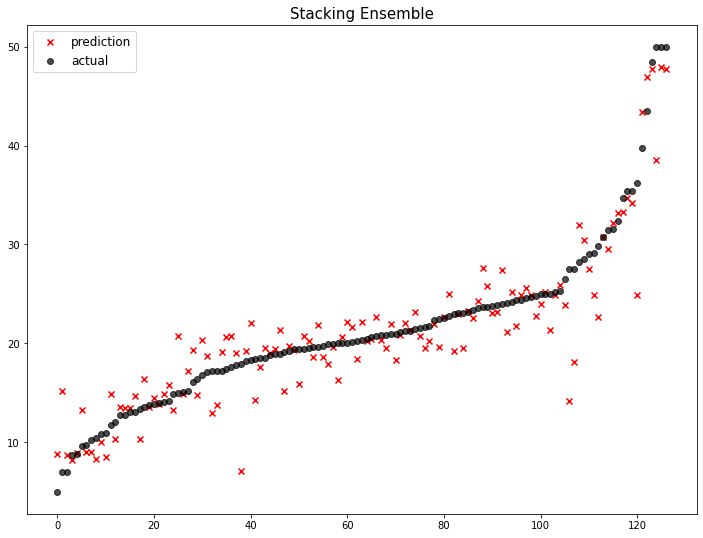

                                                model        mse
0                            ElasticNet(l1_ratio=0.8)  23.156236
1                                 Standard ElasticNet  22.694970
2                                      Ridge(alpha=1)  22.480476
3                                   Lasso(alpha=0.01)  22.210557
4                                    LinearRegression  22.098695
5                GradientBoosting ensemble(lr = 0.01)  21.982151
6                                     Voting Ensemble  20.474757
7                                     Poly ElasticNet  15.710492
8                                                LGBM  10.937726
9                               RandomForest Ensemble  10.336044
10                                     LGBM w/ Tuning  10.296543
11                   RandomForest Ensemble w/ Tunning  10.293518
12                                  Stacking Ensemble  10.210485
13                                            XGBoost  10.061070
14                       

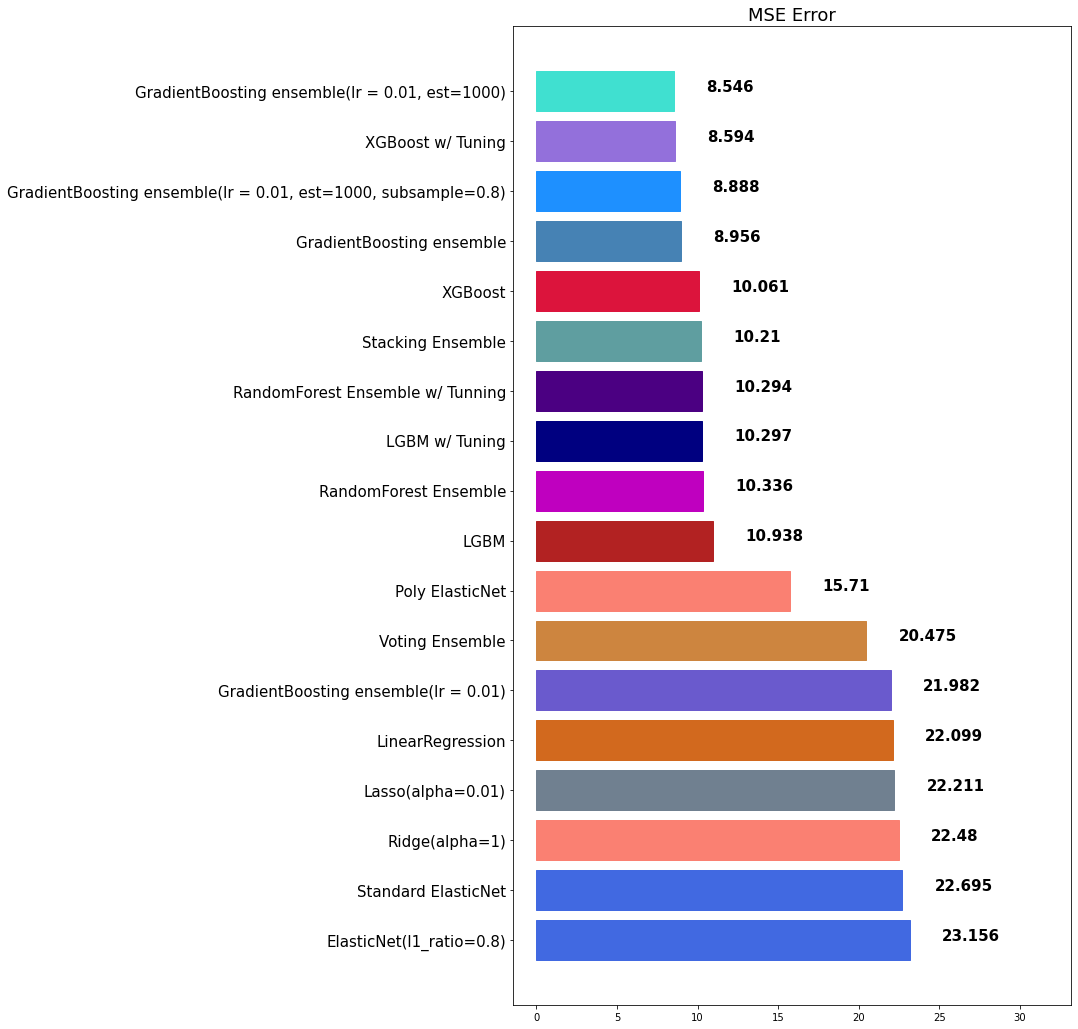

In [85]:
stack_reg =StackingRegressor(stack_models, final_estimator=xgb, n_jobs=-1)
stack_reg_pred = stack_reg.fit(x_train, y_train).predict(x_test)
mse_eval('Stacking Ensemble', stack_reg_pred, y_test)

In [ ]:
#블렌딩( Weighted Blending )
"""
각 모델의 예측값에 대하여 weight를 곱하여 최종 output을 계산
- 모델에 대한 가중치를 조절하여, 최종 output을 산출함
- 가중치의 합은 1.0 이 되도록 합니다.
"""

In [96]:
final_outputs = {
    'elasticnet': poly_pred, 
    'randomforest': rfr_pred, 
    'gbr': gbr_pred,
    'xgb': xgb_pred, 
    'lgbm': lgbm_pred,
    'stacking': stack_reg_pred,
}

In [102]:
final_prediction=\
final_outputs['elasticnet'] * 0.1\
+final_outputs['randomforest'] * 0.1\
+final_outputs['gbr'] * 0.2\
+final_outputs['xgb'] * 0.2\
+final_outputs['lgbm'] * 0.2\
+final_outputs['stacking'] * 0.2

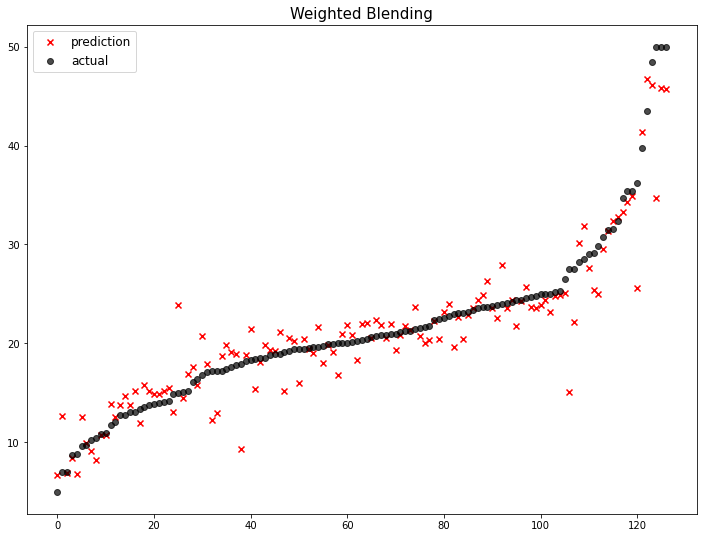

                                                model        mse
0                            ElasticNet(l1_ratio=0.8)  23.156236
1                                 Standard ElasticNet  22.694970
2                                      Ridge(alpha=1)  22.480476
3                                   Lasso(alpha=0.01)  22.210557
4                                    LinearRegression  22.098695
5                GradientBoosting ensemble(lr = 0.01)  21.982151
6                                     Voting Ensemble  20.474757
7                                     Poly ElasticNet  15.710492
8                                                LGBM  10.937726
9                               RandomForest Ensemble  10.336044
10                                     LGBM w/ Tuning  10.296543
11                   RandomForest Ensemble w/ Tunning  10.293518
12                                  Stacking Ensemble  10.210485
13                                            XGBoost  10.061070
14                       

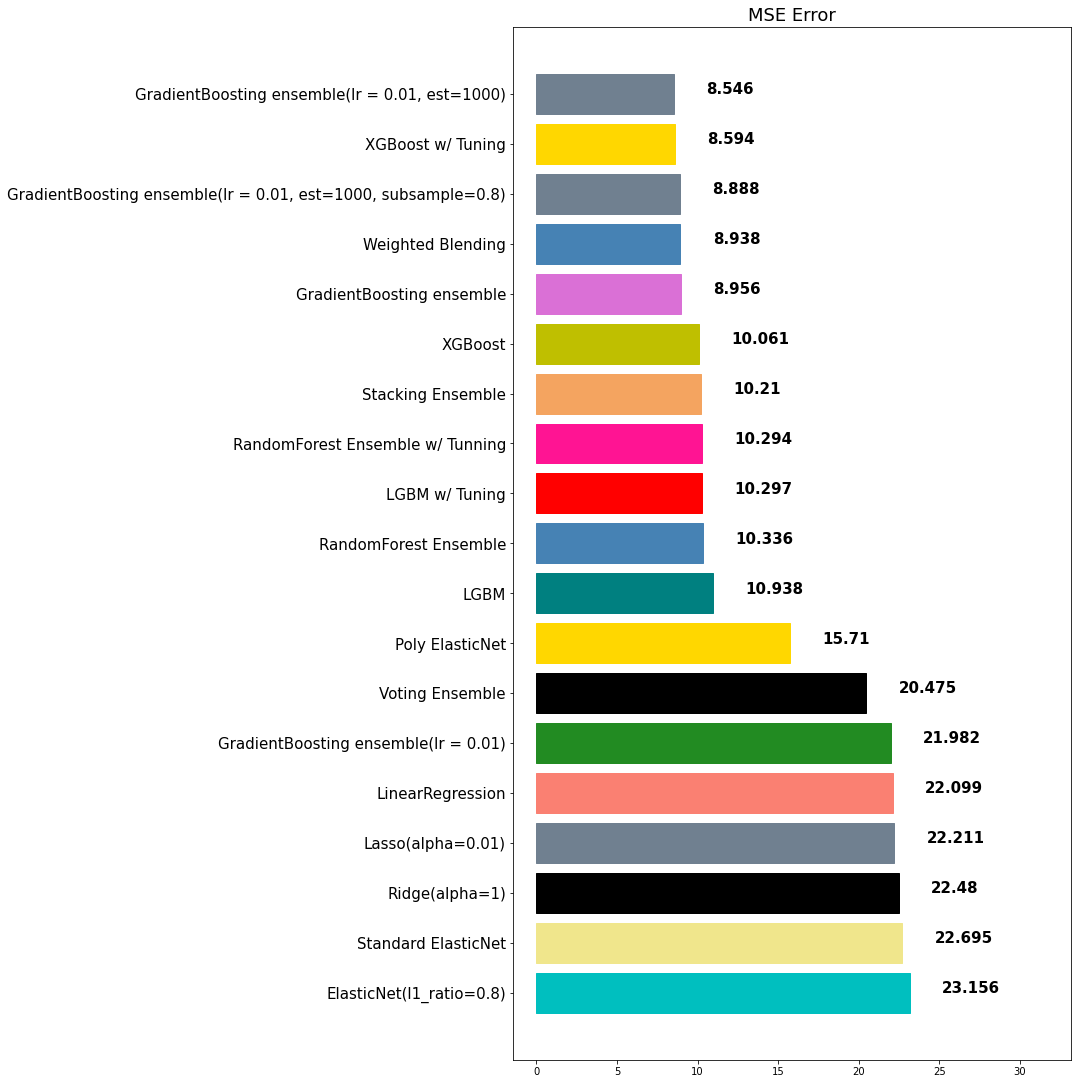

In [103]:
mse_eval('Weighted Blending', final_prediction, y_test)